In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


In [2]:
# Load stock data
stock = "AMD"
start, end = "2005-01-01", "2025-01-01"
data = yf.download(stock, start, end)

data['MA_50'] = data['Close'].rolling(50).mean()
data['MA_200'] = data['Close'].rolling(200).mean()
data['Volatility'] = data['Close'].pct_change().rolling(10).std()
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'Volume', 'MA_50', 'MA_200', 'Volatility']])

In [4]:
# Create sequences
def create_sequences(data, lookback):
    x, y = [], []
    for i in range(lookback, len(data)):
        x.append(data[i-lookback:i])
        y.append(data[i, 0])  # Predicting closing price
    return np.array(x), np.array(y)

lookback = 100
x_data, y_data = create_sequences(scaled_data, lookback)


In [5]:
# Train / Val / Test Split
train_size = int(len(x_data) * 0.7)
val_size = int(len(x_data) * 0.15)
test_size = len(x_data) - train_size - val_size

x_train, y_train = x_data[:train_size], y_data[:train_size]
x_val, y_val = x_data[train_size:train_size+val_size], y_data[train_size:train_size+val_size]
x_test, y_test = x_data[train_size+val_size:], y_data[train_size+val_size:]

# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, x_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/travis/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Train model with early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=50, callbacks=[es])


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 3.9144e-04 - val_loss: 0.0030
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 5.9431e-05 - val_loss: 0.0031
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 6.1350e-05 - val_loss: 0.0022
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 3.9431e-05 - val_loss: 0.0044
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.0594e-05 - val_loss: 0.0016
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 3.0853e-05 - val_loss: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 2.9100e-05 - val_loss: 0.0011
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.2312e-05 - val_loss: 6.0927e-04
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 2.9504e-05 - val_loss: 0.0022
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2.7212e-05 - val_loss: 0.0024
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 2.7532e-05 - val_loss: 

In [7]:
# Make predictions
predictions = model.predict(x_test)
predictions_inv = scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), scaled_data.shape[1] - 1)))))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1)))))[:, 0]


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [8]:
# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f'RMSE: {rmse}')

RMSE: 9.298175943916357


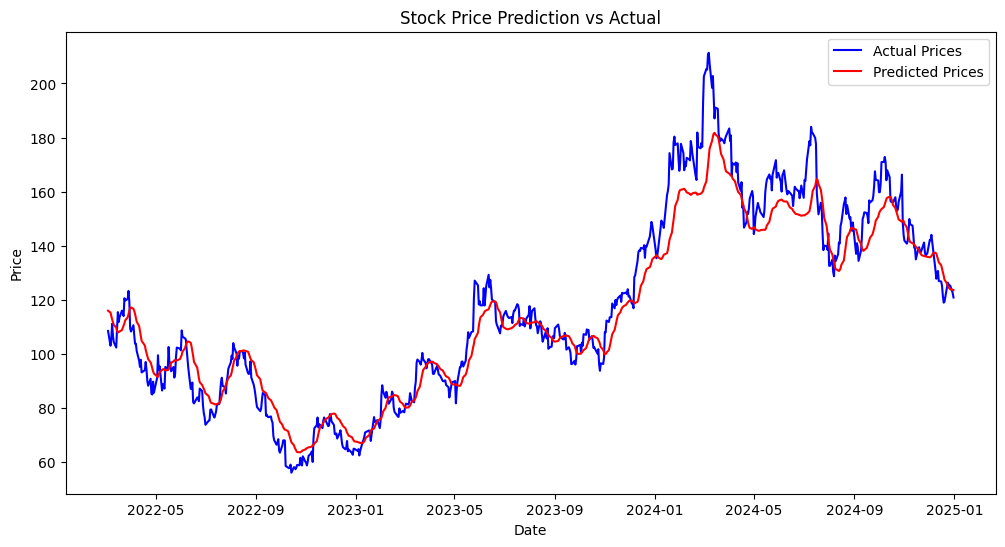

In [9]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_test_inv):], predictions_inv, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction vs Actual')
plt.legend()
plt.show()

In [10]:
# Baseline Comparison
ma_baseline = data['Close'].rolling(50).mean().iloc[-len(y_test_inv):]
persistence_baseline = data['Close'].shift(1).iloc[-len(y_test_inv):]

ma_rmse = np.sqrt(mean_squared_error(y_test_inv, ma_baseline.fillna(y_test_inv.mean())))
persistence_rmse = np.sqrt(mean_squared_error(y_test_inv, persistence_baseline.fillna(y_test_inv.mean())))

print(f'MA Baseline RMSE: {ma_rmse}')
print(f'Persistence Model RMSE: {persistence_rmse}')

MA Baseline RMSE: 14.328012155458364
Persistence Model RMSE: 3.8095199088057456
